In [1]:
import pandas as pd
import numpy as np

# visuals
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Overview

This notebook is David Robinson's college-majors R analysis translated into python.

Original Links:
- Youtube: https://www.youtube.com/watch?v=nx5yhXAQLxw&t=1428s
- R code: https://github.com/dgrtwo/data-screencasts/blob/master/college-majors.Rmd

### Data

In [2]:
recent_grads = pd.read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-10-16/recent-grads.csv'
)

In [3]:
recent_grads.head(2)

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50


In [4]:
majors_processed = recent_grads.sort_values(by='Median', ascending=False)
majors_processed.Major = majors_processed.Major.str.title()

In [5]:
majors_processed.head(2)

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,Petroleum Engineering,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,Mining And Mineral Engineering,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50


In [6]:
def weight_median(median, sample_size):
    return sum(median * sample_size) / sum(sample_size)


grouped_major_categories = majors_processed[majors_processed.Total.notnull()].groupby('Major_category')

by_major_category = grouped_major_categories.agg({'Men': 'sum',
                                                  'Women': 'sum',
                                                  'Total': 'sum'})

by_major_category['MedianSalary'] = grouped_major_categories.apply(lambda cols: 
                                                        weight_median(cols['Median'], cols['Sample_size']))

by_major_category['ShareWomen'] = by_major_category['Women'] / by_major_category['Total']

by_major_category = by_major_category.sort_values(by='ShareWomen', ascending=False).reset_index()

In [7]:
by_major_category.head(2)

,Major_category,Men,Women,Total,MedianSalary,ShareWomen
0,Health,75517.0,387713.0,463230.0,43693.740419,0.836977
1,Education,103526.0,455603.0,559129.0,32363.517503,0.814844


### What categories of majors make more money than others?

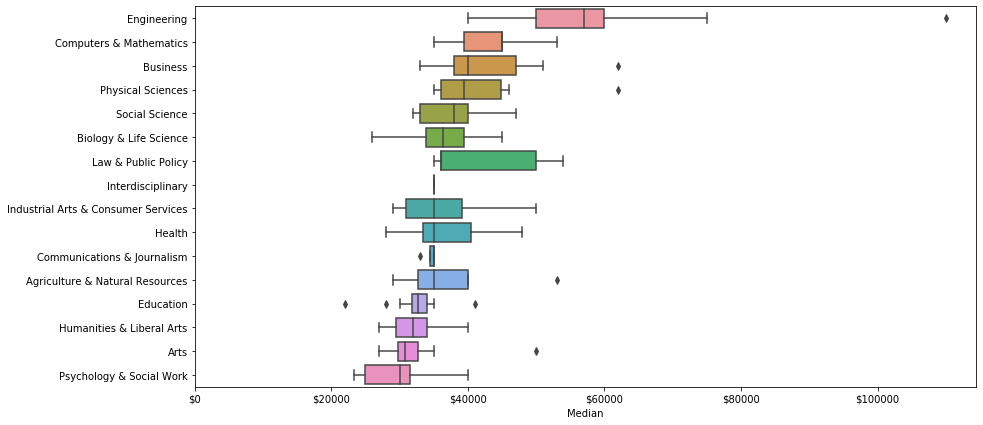

In [8]:
f, ax = plt.subplots(figsize=(14,7))

# ordering high to low based on median of category
rank = majors_processed.groupby('Major_category')['Median'].median().sort_values(ascending=False).index

sns.boxplot(x = 'Median',
            y = 'Major_category',
            data = majors_processed,
            order = rank,
            orient="h",
            ax = ax)

ax.set_ylabel(None)

# start at 0
ax.set_xlim(0,)
# prexix labels with dollar sign
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.0f'))

plt.show()

### What are the highest earning majors?

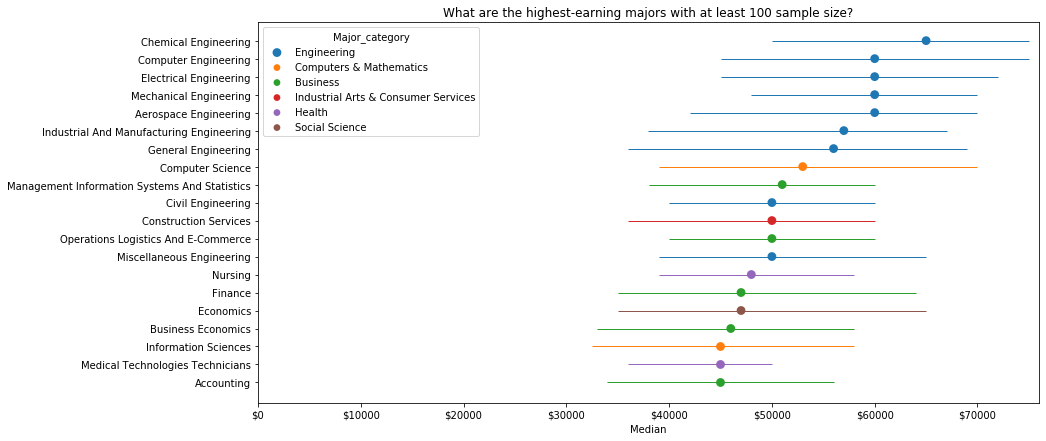

In [9]:
f, ax = plt.subplots(figsize=(14, 7))

# top 20 majors with 100 or more sample size
data = majors_processed[majors_processed.Sample_size >= 100].head(20).reset_index(drop=True)

# assigning a color for each major category
# doing this so I can use the same color when drawing the percentile lines
palette = {category: f'C{i}' for i, category in enumerate(data['Major_category'].unique())}

sns.pointplot(x = 'Median',
              y = 'Major',
              hue = 'Major_category',
              data = data,
              # prevents points in same categories drawing line between each other
              join = False,
              ax = ax,
              palette=palette)

# percentile lines
plt.errorbar(x = data.Median,
             y = np.arange(20), 
             xerr=[data.Median - data.P25th, data.P75th - data.Median], 
             yerr=[np.zeros(20), np.zeros(20)],
             ecolor = data.Major_category.map(palette),
             # stops errorbar joining x, y points
             ls = 'none',
             elinewidth=1)


ax.set_title('What are the highest-earning majors with at least 100 sample size?')

ax.set_ylabel(None)

ax.set_xlim(0, max(data['P75th']) + 1000)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.0f'))

plt.show()

### How does gender breakdown relate to typical earnings?

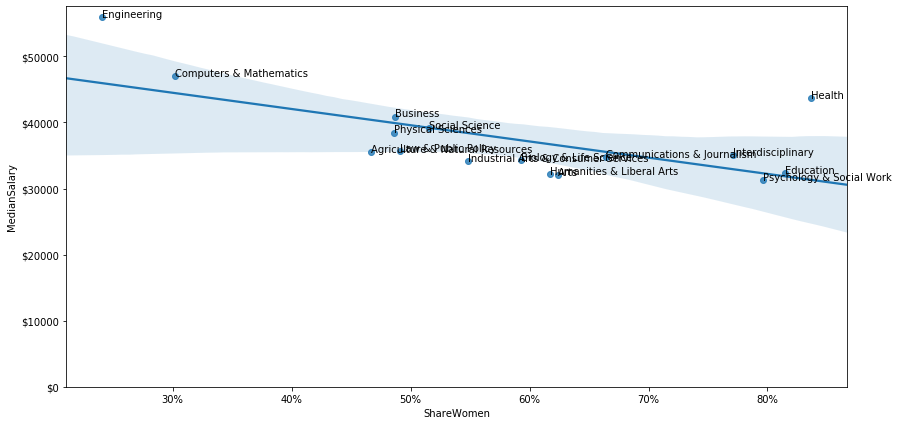

In [10]:
f, ax = plt.subplots(figsize=(14,7))

sns.regplot(x="ShareWomen", 
            y="MedianSalary",
            data=by_major_category,
            ax = ax);

for i,(text, x, y) in by_major_category[['Major_category','ShareWomen', 'MedianSalary']].iterrows():
    plt.annotate(text, (x, y))

ax.set_ylim(0,)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.0f'))

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()

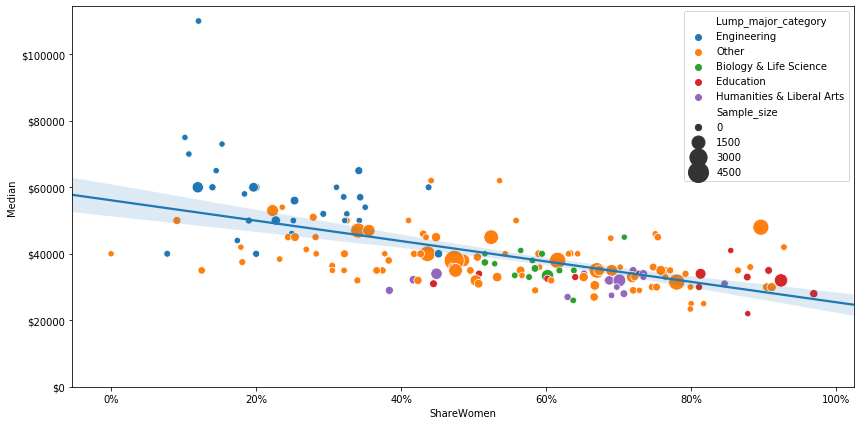

In [11]:
top_4_categories = list(majors_processed.groupby('Major_category')['Major'].count()\
                                                                    .sort_values(ascending=False).index[:4])

# lumping Major_category into 5 categories (the top 4 and 'Other' for everything else)
majors_processed['Lump_major_category'] = majors_processed['Major_category'].apply(
                                                lambda mc: mc if mc in top_4_categories else 'Other')

f, ax = plt.subplots(figsize=(14,7))

sns.scatterplot(x="ShareWomen", 
                y="Median",
                # size of points
                size='Sample_size',
                sizes=(40,400),
                data=majors_processed,
                ax=ax,
                hue='Lump_major_category')

sns.regplot(x="ShareWomen", 
            y="Median",
            data=majors_processed,
            ax = ax,
            # dont plot points
            scatter=False);

ax.set_ylim(0,)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.0f'))

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()

In [12]:
data = majors_processed[majors_processed.ShareWomen.notnull()]

# adding intecept 
X = sm.add_constant(data['ShareWomen'])
y = data['Median']

model = sm.WLS(y, X, weights=data['Sample_size'])
results = model.fit()

print(results.summary2())

                    Results: Weighted least squares
Model:                WLS               Adj. R-squared:      0.359     
Dependent Variable:   Median            AIC:                 3699.8528 
Date:                 2020-01-07 19:58  BIC:                 3706.1478 
No. Observations:     172               Log-Likelihood:      -1847.9   
Df Model:             1                 F-statistic:         96.87     
Df Residuals:         170               Prob (F-statistic):  2.26e-18  
R-squared:            0.363             Scale:               1.5128e+10
-----------------------------------------------------------------------
              Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
const       52072.7953 1436.2885 36.2551 0.0000  49237.5379  54908.0528
ShareWomen -23649.6425 2402.8285 -9.8424 0.0000 -28392.8661 -18906.4190
-----------------------------------------------------------------------
Omnibus:    

In [13]:
majors = majors_processed[majors_processed.ShareWomen.notnull()]

# removing all rows where the overall major_category has less than 10 majors
majors = majors[majors['Major_category'].map(majors.groupby('Major_category')['Major'].count() >=10)]

# applying a seperate weighted linear regression to each major category and storing RegressionResults in Results column
results = majors.groupby('Major_category').apply(
            lambda cols: sm.WLS(cols['Median'], 
                                # adding intercept to X
                                sm.add_constant(cols['ShareWomen']), 
                                weights=cols['Sample_size']).fit())\
                                                .reset_index(name='Results')

# index 1 for each as 0 relates to intecept
results['estimate'] = results['Results'].apply(lambda result: result.params[1])
results['std.error'] = results['Results'].apply(lambda result: result.bse[1])
results['statistic'] = results['Results'].apply(lambda result: result.tvalues[1])
results['p.value'] = results['Results'].apply(lambda result: result.pvalues[1])

results.drop(columns='Results', inplace=True)
results = results.sort_values(by='estimate').reset_index(drop=True)# reseting index to adjust index to new order

In [14]:
results

,Major_category,estimate,std.error,statistic,p.value
0,Biology & Life Science,-43735.061492,20982.134190,-2.084395,0.059160
1,Engineering,-33912.266631,15417.619772,-2.199579,0.036580
2,Computers & Mathematics,-28693.834382,18552.118543,-1.546661,0.156348
3,Business,-28171.186634,9810.324819,-2.871586,0.015198
4,Physical Sciences,-12820.443008,13348.584350,-0.960435,0.364962
5,Education,-1995.791497,3083.571702,-0.647234,0.527951
6,Humanities & Liberal Arts,-1813.509525,4128.103704,-0.439308,0.667652
7,Health,54721.050496,23426.631462,2.335848,0.041633


### This is scrap work.

What were the most common *majors*? (Since there were 173, we're not going to show them all).

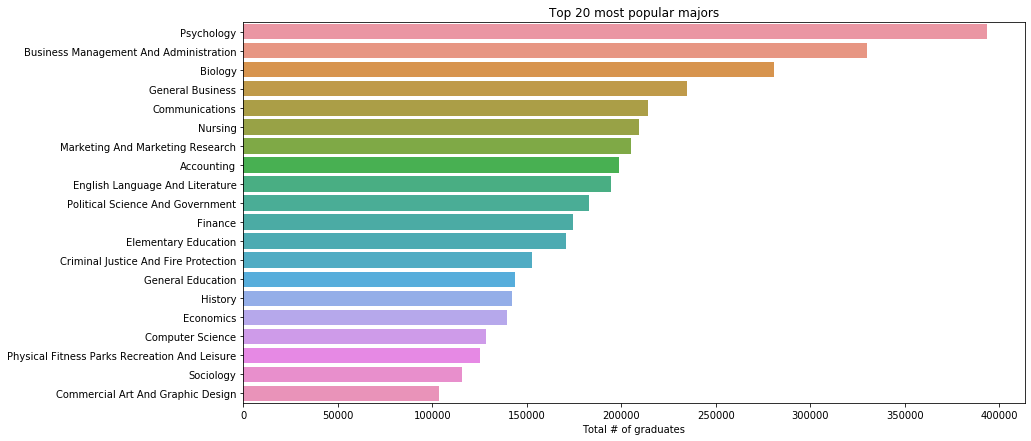

In [15]:
f, ax = plt.subplots(figsize=(14,7))

sns.barplot(y = 'Major',
            x = 'Total',
            data = majors_processed.sort_values(by='Total', ascending=False).head(20),
            orient = 'h',
            ax = ax)

ax.set_title('Top 20 most popular majors')

ax.set_xlabel('Total # of graduates')

ax.set_ylabel(None)

plt.show()

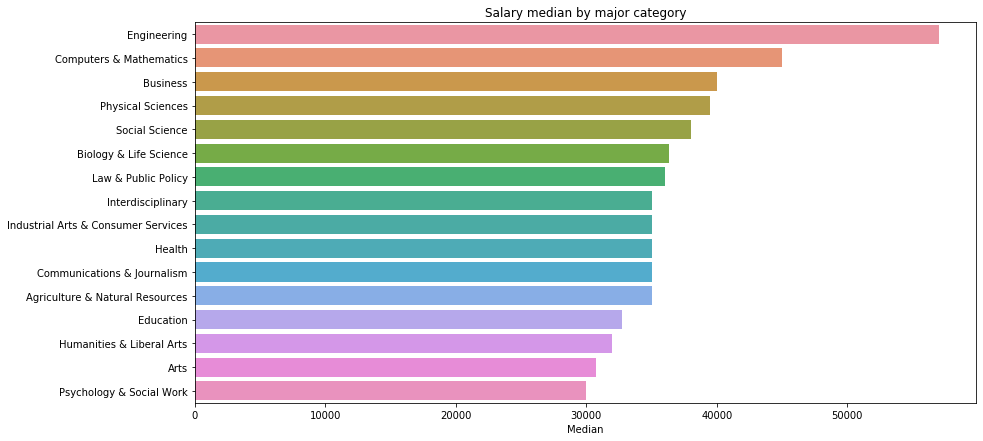

In [16]:
f, ax = plt.subplots(figsize=(14,7))

# ordering high to low based on median of category
rank = majors_processed.groupby('Major_category')['Median'].median().sort_values(ascending=False).index

sns.barplot(x = 'Median',
            y = 'Major_category',
            data = majors_processed, 
            estimator = np.median,
            order = rank,
            orient = "h",
            ax = ax,
            ci=None)

ax.set_title('Salary median by major category')

ax.set_ylabel(None)

plt.show()

What are the lowest earning majors

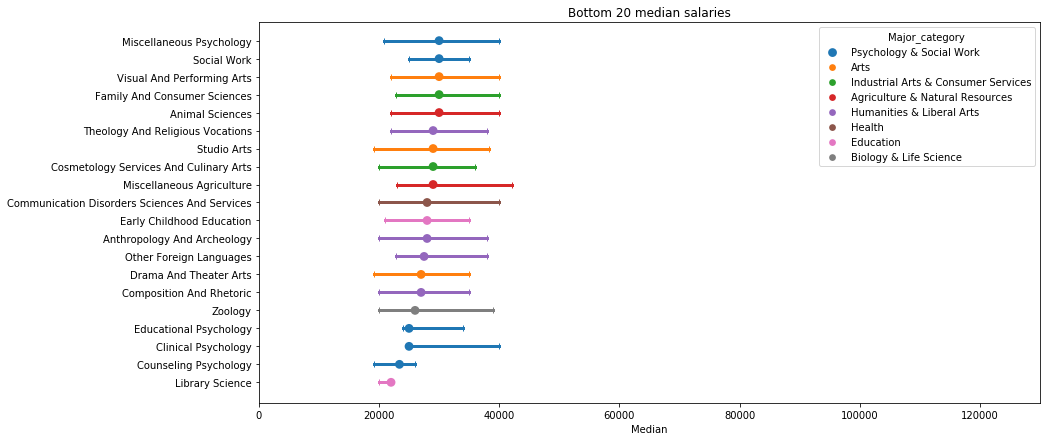

In [17]:
f, ax = plt.subplots( figsize=(14,7))

data = majors_processed.tail(20).reset_index(drop=True)

palette = {category: f'C{i}' for i, category in enumerate(data['Major_category'].unique())}

sns.pointplot(x = 'Median',
              y = 'Major',
              hue = 'Major_category',
              data = data,
              join = False,
              ax = ax,
              palette=palette)

ax.set_xlim(0, 130000)
ax.set_title('Bottom 20 median salaries')
ax.set_ylabel(None)

# custom implementaion of what plt.errorbars does
for i, (low, high, category) in data[['P25th', 'P75th', 'Major_category']].iterrows():
    plt.plot([low, high], [i, i], '|-', linewidth = 3, color = palette[category])

### Addittional
Done in stream but not in R code

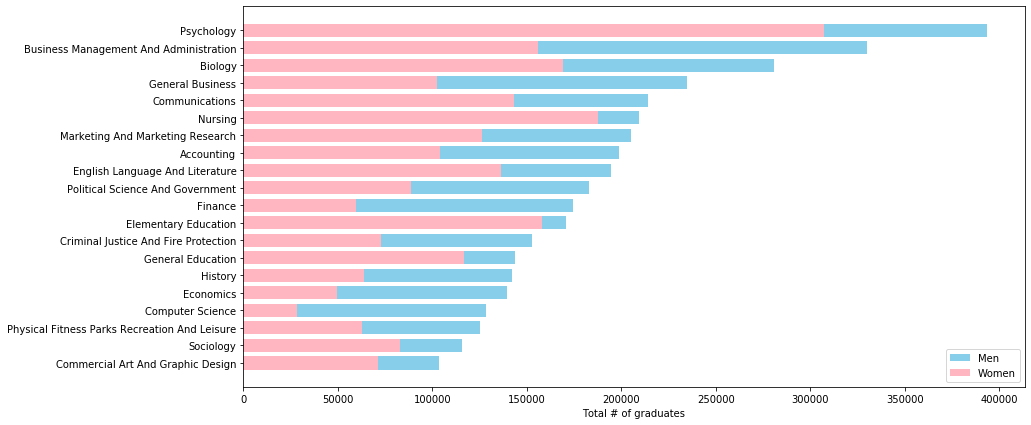

In [18]:
'''
Seaborn doesnt support stacked bar charts hence using plt
'''

f, ax = plt.subplots(figsize=(14,7))

data = majors_processed.sort_values(by='Total', ascending=False).head(20)

col_width = .75
# int points on y_axis 20->1
n = range(20,0,-1)

female_bars = plt.barh(n, data['Women'], col_width, color = 'lightpink')
male_bars = plt.barh(n, data['Men'], col_width, left=data['Women'].values, color='skyblue')

plt.yticks(n, data['Major'].values)
ax.set_ylabel(None)

ax.set_xlabel('Total # of graduates')

plt.legend((male_bars[0], female_bars[0]), ('Men', 'Women'))

plt.show()